# Homework 3

Michael Roper

## Problem 1

The following code plots the measured pressure data as a scatter plot.

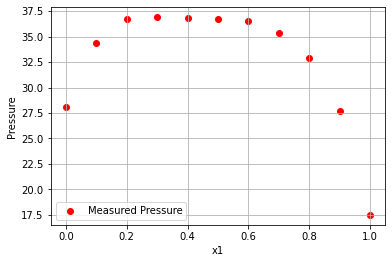

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

# Initialize measured data storage arrays.
x = np.linspace(0, 1, 11)
p = [28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]

# Plot measured data.
plt.scatter(x, p, color='red')
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.legend(['Measured Pressure'], loc="lower left")
plt.grid()
plt.show()

The minimization problem is formulated using a sum of squares method for the loss function. That is, each value calculated by the given model is subtracted from the measured value, squared, and summed, as follows (with $x_2 = 1 - x_1$):

$$
min_A   \sum_{i=1}^{N=11} \begin{pmatrix}p_i - x_{1,i}e^{A_{12}\begin{pmatrix}\frac{A_{21}(1 - x_{1,i})}{A_{12}x_{1,i} + A_{21}(1 - x_{1,i})}\end{pmatrix}^2}p^{sat}_{water} - (1 - x_{1,i})e^{A_{21}\begin{pmatrix}\frac{A_{12}x_{1,i}}{A_{12}x_{1,i} + A_{21}(1 - x_{1,i})}\end{pmatrix}^2}p^{sat}_{1, 4 dioxane}\end{pmatrix}^2
$$

[1.9576997 1.6897758]
0.670233


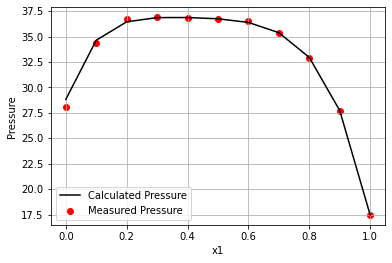

The model fits well with the data:  True


In [2]:
import torch as t
from torch.autograd import Variable
import numpy as np
from math import *
import matplotlib.pyplot as plt
from random import random

# Calculate saturation pressures with given values and Antoine equation.
a = [[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]
T = 20
p_sat_water = 10**(a[0][0] - a[0][1]/(T + a[0][2]))
p_sat_dioxane = 10**(a[1][0] - a[1][1]/(T + a[1][2]))

# Initialize measured data storage arrays.
x = np.linspace(0, 1, 11)
p = [28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]

# Define variable A.
A = Variable(t.tensor([random(), random()]), requires_grad=True)

# Define loss function.
def compute_loss(x, p, A):
    f = t.zeros(len(p))
    for i in range(len(p)):
        f[i] = (p[i] - x[i]*p_sat_water*t.exp(A[0]*(A[1]*(1 - x[i])/(A[0]*x[i] + A[1]*(1 - x[i])))**2)
                - (1 - x[i])*p_sat_dioxane*t.exp(A[1]*(A[0]*x[i]/(A[0]*x[i] + A[1]*(1 - x[i])))**2))**2
    return t.sum(f)

# Define line search algorithm.
def line_search(x, p, A, k):
    with t.no_grad():
        alpha = 0.001
        phi = compute_loss(x, p, A) - alpha*k*t.dot(A.grad, A.grad)
        while phi < compute_loss(x, p, A - alpha*A.grad):
            alpha = 0.5*alpha
            phi = compute_loss(x, p, A) - alpha * k * t.dot(A.grad, A.grad)
        return alpha

# Perform gradient descent with line search.
for j in range(200):
    loss = compute_loss(x, p, A)
    loss.backward()

    alpha = line_search(x, p, A, 0.8)
    # alpha = .001

    with t.no_grad():
        A -= alpha*A.grad
        A.grad.zero_()

# Print solution and minimum loss.
print(A.data.numpy())
print(loss.data.numpy())

# Calculate pressure with minimization solution for A.
soln = A.data.numpy()
p_soln = []
for i in range(len(x)):
    p_soln.append([])
    p_soln[i] = x[i] * p_sat_water * exp(
        soln[0] * (soln[1] * (1 - x[i]) / (soln[0] * x[i] + soln[1] * (1 - x[i]))) ** 2) + \
                (1 - x[i]) * p_sat_dioxane * exp(
        soln[1] * (soln[0] * x[i] / (soln[0] * x[i] + soln[1] * (1 - x[i]))) ** 2)

plt.scatter(x, p, color='red')
plt.plot(x, p_soln, color='black')
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.legend(['Calculated Pressure', 'Measured Pressure'])
plt.grid()
plt.show()

print('The model fits well with the data: ', np.allclose(p_soln, p, rtol=1e-1))

The minimization solution for $A_{12}$ and $A_{21}$ values were determined to be 1.96 and 1.69, respectively. The plot above shows the measured pressure data (red) and the pressure calculated with this solution (black).

## Problem 2

The following code was written by Thomas Huijskens and adapted for Problem 2.

In [3]:
import sklearn.gaussian_process as gp
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize


def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):

    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        cv_score = sample_loss(next_sample)

        x_list.append(next_sample)
        y_list.append(cv_score)

        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp


x = np.array([[-3, 3], [-2, 2]])


def func(z):
    return (4 - 2.1*z[0]**2 + (z[0]**4)/3)*z[0]**2 + z[0]*z[1] + (-4 + 4*z[1]**2)*z[1]**2


soln = bayesian_optimisation(n_iters=10, sample_loss=func, bounds=x, x0=None, n_pre_samples=5)
print(soln[0])

[[-2.69797089 -1.99474486]
 [ 0.64921962  1.3625639 ]
 [-2.94786999 -1.14760608]
 [-0.92805658  1.27485452]
 [ 0.5065238   0.41858652]
 [-3.         -1.73843372]
 [-2.3534579  -0.19625628]
 [ 1.97301192  0.66943172]
 [ 0.47677547  0.041483  ]
 [ 2.36527633 -1.85494437]
 [ 1.30017418 -0.74319372]
 [ 1.21395481 -1.54058284]
 [ 0.18955308  0.43149846]
 [ 2.2987136  -0.78548625]
 [-1.39629466 -1.64707576]]


The solutions above were determined to be optimal by the Bayesian Optimization algorithm.